<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from numpy import asarray
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
categories = ['NORMAL','PNEUMONIA']
img_size = 224 

def get_images(dir): 
    images_array = []
    for category in categories: 
        path = os.path.join(dir, category)
        label = categories.index(category)
        for image in tqdm(os.listdir(path)): 
            try:
                img_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # set image size 
                images_array.append([resized_arr, label])
            except Exception as e:
                print(e)
    return np.array(images_array)

train = get_images('/content/drive/MyDrive/Pneumonia/train')
test = get_images('/content/drive/MyDrive/Pneumonia/test')
val = get_images('/content/drive/MyDrive/Pneumonia/val')

100%|██████████| 1359/1359 [01:11<00:00, 19.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


#Image preprocessing
- Augmentation with, without and balanced augmentation (oversampling normal data)

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for pixels, label in train:
    x_train.append(pixels)
    y_train.append(label)

for pixels, label in test:
    x_test.append(pixels)
    y_test.append(label)
    
for pixels, label in val:
    x_val.append(pixels)
    y_val.append(label)

# resize data for neural network training
x_train = np.array(x_train).reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = np.array(x_val).reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
epoch_size = 15
batch_size = 32 

train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
valid_generator = train_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=1)

[0]


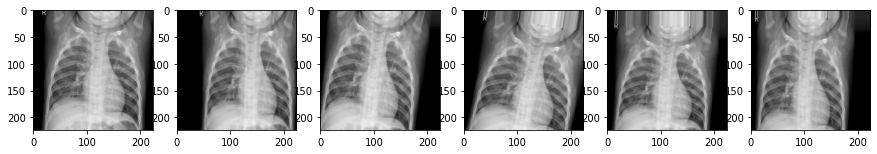

In [10]:
#augmented images of a sample image 
fig, axes = plt.subplots(1,6,figsize=(15,15))
axes[0].imshow(x_train[0][:,:,0], cmap='gray') #first image in the training set (original: non-augmented)
for i in range(5): #display five generated augmented images
  sample, label = train_datagen.flow(x_train[:1], y_train[:1]).__getitem__(0)
  for img in sample: 
    axes[i+1].imshow(img[:,:,0], cmap='gray')
print("class: ", categories[label[0]])

In [11]:
#@title create_plot
def create_plot(history, epoch_size): 
    epochs = [i for i in range(epoch_size)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(12,6)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [12]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size= batch_size):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

balanced_gen = BalancedDataGenerator(x_train, y_train, train_datagen, batch_size=32) 
steps_per_epoch = balanced_gen.steps_per_epoch #generated_image, label = train.__getitem__(18)
y_gen = [balanced_gen.__getitem__(0)[1] for i in range(steps_per_epoch)]
print(np.unique(y_gen, return_counts=True)) #number of each label changes every training *

(array([0, 1]), array([3919, 3921]))


#Modeling

In [16]:
#model 
def create_model(): 
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224,224,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    return model
# model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

Epoch 1/15
166/166 [==============================] - 24s 140ms/step - loss: 0.4116 - accuracy: 0.8934 - val_loss: 14.2997 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
166/166 [==============================] - 24s 147ms/step - loss: 0.1639 - accuracy: 0.9371 - val_loss: 3.6768 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
166/166 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9501
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 23s 137ms/step - loss: 0.1370 - accuracy: 0.9501 - val_loss: 9.2846 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
166/166 [==============================] - 23s 138ms/step - loss: 0.1121 - accuracy: 0.9577 - val_loss: 9.1073 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/15
166/166 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9677
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
166/166 [=====================

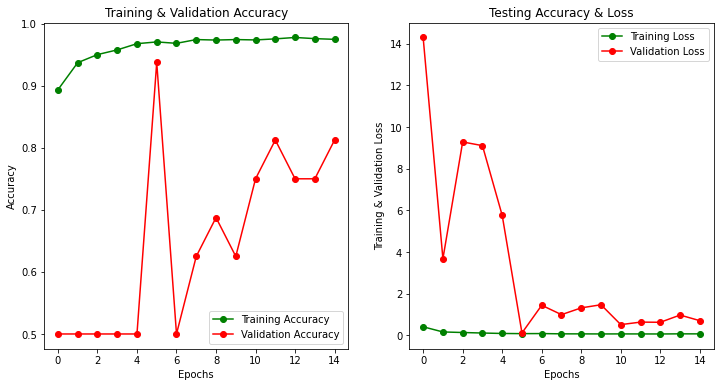

In [17]:
#with augmentation
model = create_model()
history = model.fit(train_generator, epochs=epoch_size, validation_data=valid_generator, callbacks = [learning_rate_reduction])
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)

Epoch 1/15
245/245 [==============================] - 35s 140ms/step - loss: 0.3531 - accuracy: 0.9094 - val_loss: 34.8191 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
245/245 [==============================] - 34s 136ms/step - loss: 0.1558 - accuracy: 0.9443 - val_loss: 37.8229 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
245/245 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9489
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
245/245 [==============================] - 34s 139ms/step - loss: 0.1351 - accuracy: 0.9489 - val_loss: 2.0173 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
245/245 [==============================] - 36s 145ms/step - loss: 0.0981 - accuracy: 0.9653 - val_loss: 11.2782 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/15
245/245 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9714
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
245/245 [===================

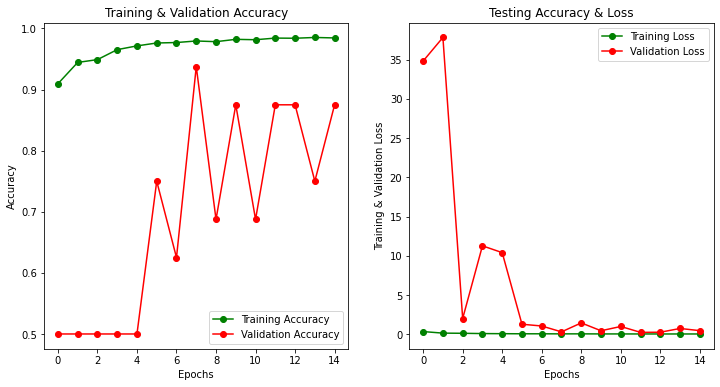

In [18]:
#balanced augmentation
model = create_model()
history = model.fit(balanced_gen, epochs = epoch_size , validation_data = valid_generator, callbacks = [learning_rate_reduction])
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)

Epoch 1/15
166/166 [==============================] - 41s 143ms/step - loss: 0.3967 - accuracy: 0.8976 - val_loss: 11.5935 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
166/166 [==============================] - 24s 144ms/step - loss: 0.1481 - accuracy: 0.9460 - val_loss: 11.7435 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
166/166 [==============================] - 22s 135ms/step - loss: 0.1389 - accuracy: 0.9473 - val_loss: 1.9238 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/15
166/166 [==============================] - 22s 134ms/step - loss: 0.1401 - accuracy: 0.9465 - val_loss: 13.0681 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/15
166/166 [==============================] - 27s 163ms/step - loss: 0.1157 - accuracy: 0.9562 - val_loss: 0.4452 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/15
166/166 [==============================] - 23s 141ms/step - loss: 0.1203 - accuracy: 0.9596 - val_loss: 0.7512 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/15
166/166 [=============================

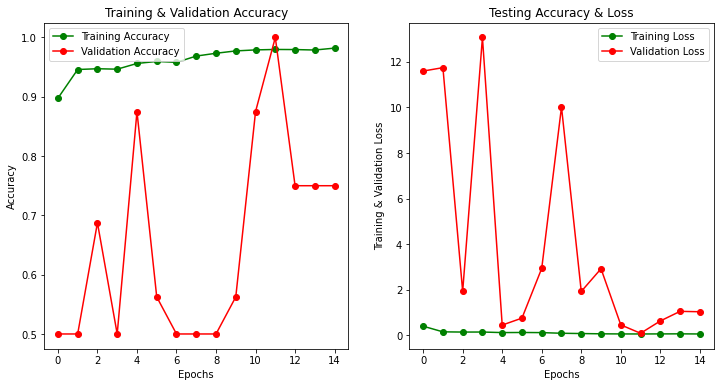

In [20]:
#without augmentation
model = create_model()
history = model.fit(train_generator, epochs = epoch_size , validation_data = valid_generator, callbacks = [learning_rate_reduction])
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)

In [23]:
from keras.preprocessing import image
import keras
from keras.models import load_model
import matplotlib.pyplot as plt
from keras import models
%matplotlib inline
from keras.applications.vgg16 import VGG16
vgg_model = VGG16()

553476096/553467096 [==============================] - 20s 0us/step


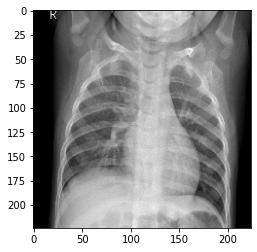

In [24]:
img_name = os.listdir('/content/drive/MyDrive/Pneumonia/train/PNEUMONIA')[0]
img_path = '/content/drive/MyDrive/Pneumonia/train/PNEUMONIA/' + img_name

#Preprocess the image into a 4D tensor
img = image.load_img(img_path, target_size=(img_size,img_size))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# The model was trained on inputs that were preprocessed in the following way:
img_tensor /= 255. # 

#display the image
plt.imshow(img_tensor[0])
plt.show()

In [35]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

In [25]:
layer_names = [layer.name for layer in vgg_model.layers]
layer_names #23 but 18 layers

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten',
 'fc1',
 'fc2',
 'predictions']

In [28]:
layer_names = [layer.name for layer in model.layers]
print(len(layer_names))
layer_names

22


['conv2d',
 'batch_normalization',
 'max_pooling2d',
 'conv2d_1',
 'dropout',
 'batch_normalization_1',
 'max_pooling2d_1',
 'conv2d_2',
 'batch_normalization_2',
 'max_pooling2d_2',
 'conv2d_3',
 'dropout_1',
 'batch_normalization_3',
 'max_pooling2d_3',
 'conv2d_4',
 'dropout_2',
 'batch_normalization_4',
 'max_pooling2d_4',
 'flatten',
 'dense',
 'dropout_3',
 'dense_1']

In [30]:
# Extracts the outputs of the top layers everything upto the GAP layer:
layer_outputs = [layer.output for layer in model.layers[1:18]] #this model has 18 layers just before the GAP layer

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [32]:
img_tensor.shape

(1, 224, 224, 3)

In [34]:
xr = img_tensor.reshape((-1,1))
xr.shape

(150528, 1)

In [31]:
# This will return a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

# This is the activation of the first convolution layer for our image input:
second_layer_activation = activations[1]
print(second_layer_activation.shape) #(1, 300, 300, 64)

#It's a 300*300 feature map with 64 channels. Visualizing the 60th and 10th channel:
plt.matshow(second_layer_activation[0, :, :, 60], cmap='viridis')
plt.show()

#This channel appears to encode a diagonal edge detector. 
# 10th channel, since the specific filters learned by convolution layers are not deterministic.
plt.matshow(second_layer_activation[0, :, :, 10], cmap='viridis')
plt.show()

ValueError: ignored